In [1]:
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.collections import PatchCollection

import math
import itertools


In [2]:
TOPICS = ["CLIMATE", "IMMIGRATION", "SOCIAL_SECURITY", "ECONOMIC_POLICY", "EDUCATION", "SDP", "FINNS", "NATIONAL", "CENTER", "GREEN", "LEFT", "PARTIES", "EUROVISION", "WILMAMURTO"]

df = pd.read_pickle("./2023-NMI.pkl")  
df.columns = TOPICS
df.index = TOPICS


In [3]:
G = nx.Graph()

for T1 in TOPICS:
    if T1=="PARTIES":
        continue
    for T2 in TOPICS:
        if T2=="PARTIES":
            continue
        G.add_edge(T1, T2, weight=df[T1][T2])
        
G.remove_edges_from(nx.selfloop_edges(G))

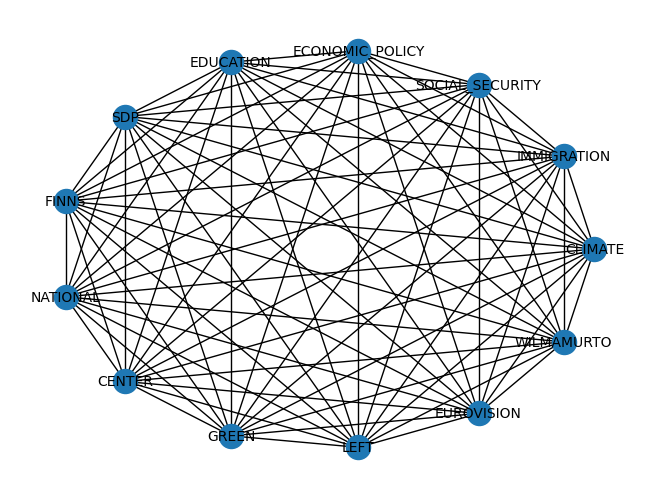

In [4]:
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, font_size=10)

In [5]:
def get_simplices(G, d=None) :
    
    """Return list of all d-simplices"""
    
    all_simplices = list(nx.enumerate_all_cliques(G))
    
    if d==None:
        return [tuple(sorted(simplex)) for simplex in all_simplices]
    else :
        return [tuple(sorted(simplex)) for simplex in all_simplices if len(simplex)==d+1]
    
def get_max_simplices(G, d=None) :
    
    """Return list of all maximal simplices"""
    
    max_simplices = list(nx.find_cliques(G))
    
    if d==None :
        return [tuple(sorted(simplex)) for simplex in max_simplices]
    else : 
        return [tuple(sorted(simplex)) for simplex in max_simplices if len(simplex)==d+1]
    
def get_highest_order(G) :
    
    """Return d of largest d-simplex"""
    maximal_simplices = list(nx.find_cliques(G))
    sizes = [len(simplex) for simplex in maximal_simplices]
    return max(sizes) - 1

def plot_simplicial(G, ax=None, pos=None, params=None, projected=False) :
    
    """
    Plot simplicial complex built from networkx Graph G, by promoting cliques to simplices
    
    Parameters
    -----------
    
    G : networkx Graph
    
    ax : matplotlib.pyplot.axes 
        If None (default), current axes
    
    pos : dict 
        Dictionary of positions d:(x,y) is used for placing the 0-simplices.
        If None (default), nx.nx_agraph.pygraphviz_layout() is used.
            
    params : dict 
        Dictionary of parameters to plot, such as node colour etc (see networkx.draw)
        
    projected : bool
        If True, draw graph without higher-order simplices
        
    Return
    ------
    
    None
    
    """
    
    # 0-simplices
    nodes = list(G.nodes)
    # 1-simplices
    edges = list(G.edges)
    # 2-simplices 
    triangles = get_simplices(G, d=2)
    # 2-simplices (maximal)
    triangles_max = get_max_simplices(G, d=2)
    # max simplicial order
    d_max = get_highest_order(G)
    
    if ax==None:
        ax = plt.gca()    
        
    if pos==None:
        pos = nx.spring_layout(G)
    
    if params==None :
        params =  {
             'with_labels': True,
            'node_color': 'k',
            #'edge_color': 'C0', 
            #'width' : 2,
            'font_color': 'k',
            'node_size' : 100
          }

    # draw nodes
    nx.draw_networkx(G, pos=pos, ax=ax, **params)
    # draw edges
    nx.draw_networkx(G, pos=pos, ax=ax, **params)
    # draw triangles
    
    if not projected : # draw higher-order simplices
        
        for triangle in triangles: # or triangles
            (i, j, k) = triangle
            (x0, y0) = pos[i]
            (x1, y1) = pos[j]
            (x2, y2) = pos[k]

            if triangle in triangles_max :
                fc = 'C1'
                zorder = -3
                alpha = 0.4
            else: 
                fc = 'k'
                zorder = -2
                alpha = 0.1 # change if need all polygons

            tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                              facecolor = fc,
                              zorder=zorder, alpha=alpha, lw=0.5)
            ax.add_patch(tri)
        
    return ax

In [6]:
def plot_simplicial_pure(G, d, ax=None, pos=None, params=None) :
    
    """
    Plot simplicies of order d only, from the simplicial complex built from networkx Graph G, 
    by promoting cliques to simplices
    
    Parameters
    -----------
    
    G : networkx Graph
    
    d : int
        Draw nodes and simplices of order d only
    
    ax : matplotlib.pyplot.axes 
        If None (default), current axes
    
    pos : dict 
        Dictionary of positions d:(x,y) is used for placing the 0-simplices.
        If None (default), nx.nx_agraph.pygraphviz_layout() is used.
            
    params : dict 
        Dictionary of parameters to plot, such as node colour etc (see networkx.draw)
        
    Return
    ------
    
    None
    
    """
    
    # max simplicial order
    d_max = get_highest_order(G)
    
    if d > d_max :
        print("There is no d-simplex or higher in the network.")
        print("Try a smaller d.")
        
    simplices = get_simplices(G, d=d)
    # 0-simplices
    nodes = list(G.nodes)
    
    if ax==None:
        ax = plt.gca()    
        
    if pos==None:
        pos = nx.spring_layout(G)
    
    if params==None :
        params =  {
#             'with_labels': True,
            #'node_color': 'k',
            #'edge_color': 'C0', 
            #'width' : 2,
            #'font_color': 'k',
            #'node_size' : 100
          }

    # draw nodes
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **params)
    
    if d==1 : 
        # draw edges
        nx.draw_networkx_edges(G, pos=pos, ax=ax, **params)
        ax.set_rasterization_zorder(-2)
    elif d==2 :
        triangles = simplices
        patches = []

        # draw triangles
        for triangle in triangles:
            (i, j, k) = triangle
            (x0, y0) = pos[i]
            (x1, y1) = pos[j]
            (x2, y2) = pos[k]
            
            tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                              facecolor = 'C1',
                              zorder=-4, alpha=0.4, lw=0.5)
#             ax.add_patch(tri)
            patches.append(tri)
    
            edge_list = list(itertools.combinations(triangle, 2))
            nx.draw_networkx_edges(G, edgelist=edge_list, pos=pos, ax=ax, edge_color=f'C1', width=0.5)
        
        p = PatchCollection(patches, facecolor = f'C1',
                                  zorder=-4, alpha=0.4, lw=0.5)
        ax.add_collection(p)
        ax.set_rasterization_zorder(-2)

    elif d>=3 :
        
#         patches = []
        
#         for simplex in simplices :
#             for triangle in itertools.combinations(simplex, 3) :
#                 (i, j, k) = triangle
#                 (x0, y0) = pos[i]
#                 (x1, y1) = pos[j]
#                 (x2, y2) = pos[k]

#                 tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
#                                   facecolor = f'C{d-1}',
#                                   zorder=-2, alpha=0.4, lw=0.5)
#                 patches.append(tri)
            
#             edge_list = list(itertools.combinations(simplex, 2))
#             nx.draw_networkx_edges(G, edgelist=edge_list, pos=pos, ax=ax, edge_color=f'C{d-1}', lw=0.5, zorder=-3)

#         p = PatchCollection(patches, facecolor = f'C{d-1}',
#                                   zorder=-2, alpha=0.4, lw=0.5)
#         ax.add_collection(p)
        
#         possibly draw d-simplex as d-polygone, but no 3d effect, very flat
        patches = []

        for simplex in get_simplices(G, d) :

            x = [None]*(d+1)
            y = [None]*(d+1)

            vertices = []
            for i, node in enumerate(simplex): #in range(d+1) :
                (x[i], y[i]) = pos[node]
                vertices.append([x[i], y[i]])

            # compute centroid
            cent = (sum([v[0] for v in vertices]) / len(vertices), sum([v[1] for v in vertices]) / len(vertices))
            # sort by polar angle
            vertices.sort(key=lambda v: math.atan2(v[1] - cent[1], v[0] - cent[0]))

            d_simplex = plt.Polygon(vertices,
                              facecolor = "violet",
                              zorder = -4, alpha=0.5, lw=0.5)
            patches.append(d_simplex)
            
            edge_list = list(itertools.combinations(simplex, 2))
            nx.draw_networkx_edges(G, edgelist=edge_list, pos=pos, ax=ax, edge_color=f'C{d-1}', width=0.5)

        p = PatchCollection(patches, facecolor = f'C{d-1}',
                                  zorder=-4, alpha=0.4, lw=0.5)
        ax.add_collection(p)
        ax.set_rasterization_zorder(-2)
#             ax.add_patch(d_simplex)
        
    return

In [7]:
#G_threshold = nx.Graph(((source, target, attr) for source, target, attr in G.edges_iter(data=True) if attr['weight'] > 0.8))

def get_subgraph(G, threshold):
    G_threshold = nx.Graph()

    for (u, v, w) in G.edges.data('weight'):
        if w > threshold:
            G_threshold.add_edge(u, v, weight=w)
        else:
            G_threshold.add_node(u)
            G_threshold.add_node(v)
    
    return G_threshold

G_sub = get_subgraph(G, 0.61)


<Axes: >

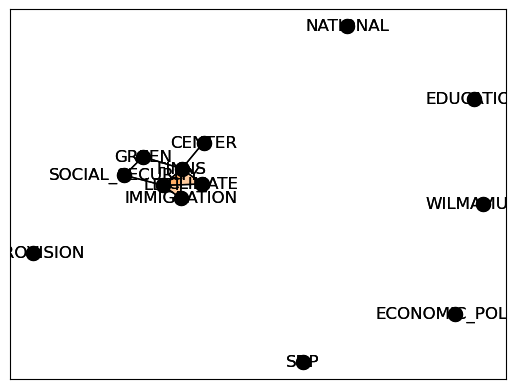

In [8]:
plot_simplicial(G_sub)

[]

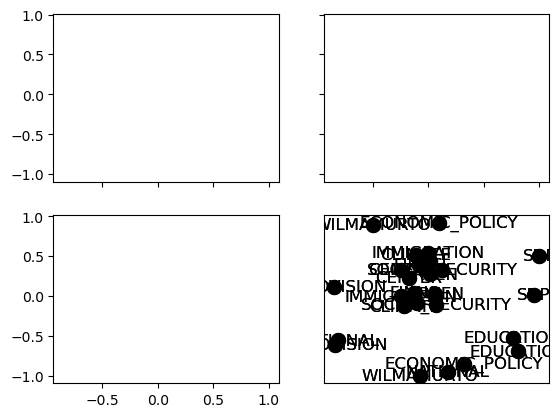

In [9]:
import matplotlib.pyplot as plt
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = axes.flatten()

plot_simplicial(G_sub).plot()
plot_simplicial(G_sub).plot()

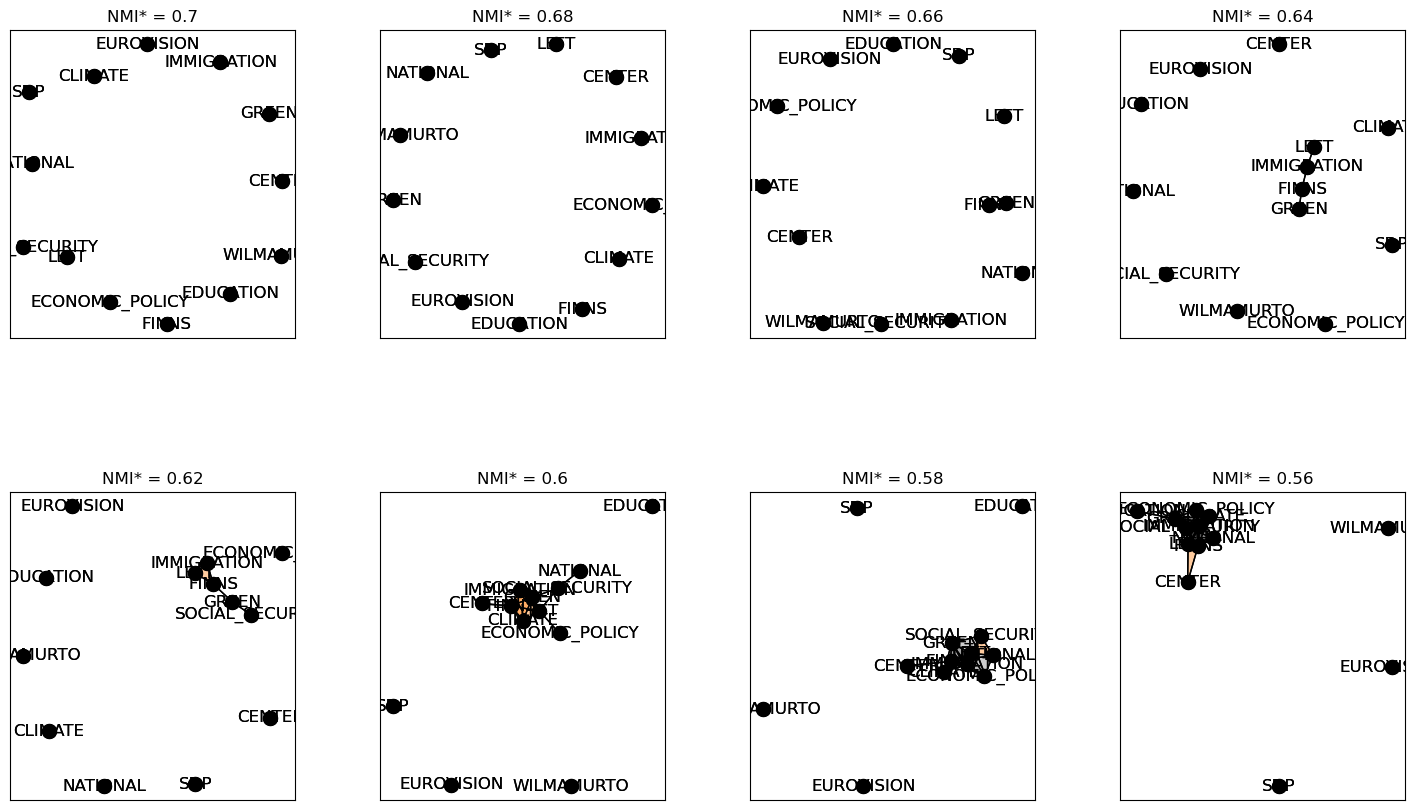

In [10]:
def create_subplot_grid_2x4():
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.5)

    #ax_idx = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]

    return fig, ax

fig, ax = create_subplot_grid_2x4()

ax_idx = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
omega = [0.7, 0.68, 0.66, 0.64, 0.62, 0.6, 0.58, 0.56]

for x,y in zip(ax_idx, omega):

    G_sub = get_subgraph(G, y)
    plot_simplicial(G_sub, ax=ax[x])
    ax[x].set_title(f'NMI* = {y}')

<Axes: >

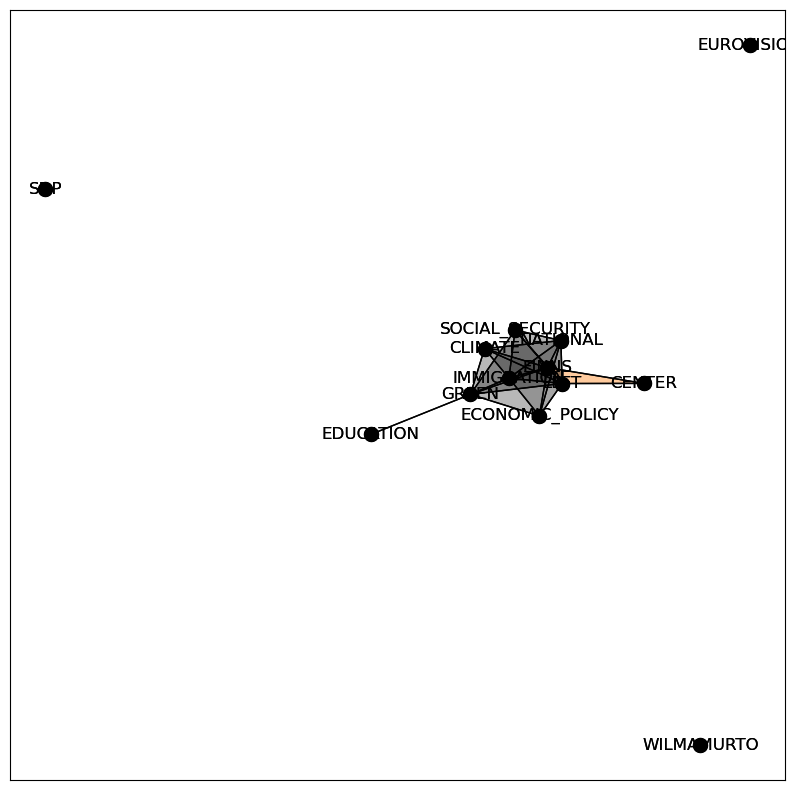

In [20]:


fig = plt.figure(figsize=(10, 10))
G_sub = get_subgraph(G, 0.55)
plot_simplicial(G_sub)

# ANOTHER PLOTTING LIBRARY

In [21]:
import networkx as nx
import itertools

import matplotlib.pyplot as plt
%matplotlib inline 

def draw_2d_simplicial_complex(simplices, pos=None, return_pos=False, ax = None):
    """
    Draw a simplicial complex up to dimension 2 from a list of simplices, as in [1].
        
        Args
        ----
        simplices: list of lists of integers
            List of simplices to draw. Sub-simplices are not needed (only maximal).
            For example, the 2-simplex [1,2,3] will automatically generate the three
            1-simplices [1,2],[2,3],[1,3] and the three 0-simplices [1],[2],[3].
            When a higher order simplex is entered only its sub-simplices
            up to D=2 will be drawn.
        
        pos: dict (default=None)
            If passed, this dictionary of positions d:(x,y) is used for placing the 0-simplices.
            The standard nx spring layour is used otherwise.
           
        ax: matplotlib.pyplot.axes (default=None)
        
        return_pos: dict (default=False)
            If True returns the dictionary of positions for the 0-simplices.
            
        References
        ----------    
        .. [1] I. Iacopini, G. Petri, A. Barrat & V. Latora (2019)
               "Simplicial Models of Social Contagion".
               Nature communications, 10(1), 2485.
    """

    
    #List of 0-simplices
    nodes =list(set(itertools.chain(*simplices)))
    
    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in simplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in simplices])))
    
    if ax is None: ax = plt.gca()
    ax.set_xlim([-1.1, 1.1])      
    ax.set_ylim([-1.1, 1.1])
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('off')
       
    if pos is None:
        # Creating a networkx Graph from the edgelist
        G = nx.Graph()
        G.add_edges_from(edges)
        # Creating a dictionary for the position of the nodes
        pos = nx.spring_layout(G)
        
    # Drawing the edges
    for i, j in edges:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = 'black', zorder = 1, lw=0.7)
        ax.add_line(line);
    
    # Filling in the triangles
    for i, j, k in triangles:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        (x2, y2) = pos[k]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'black', facecolor = plt.cm.Blues(0.6),
                          zorder = 2, alpha=0.4, lw=0.5)
        ax.add_patch(tri);

    # Drawing the nodes 
    for i in nodes:
        (x, y) = pos[i]
        circ = plt.Circle([ x, y ], radius = 0.02, zorder = 3, lw=0.5,
                          edgecolor = 'Black', facecolor = u'#ff7f0e')
        ax.add_patch(circ);

    if return_pos: return pos

In [29]:
simplices = [[0,1],[1,2,3],[2,4],[4,5,6,7],[4,0],[0,2],[0,9,10],[9,10,11,12],[10,11,12,13]]
simplices = [[0, 1], [1,2,3,4]]

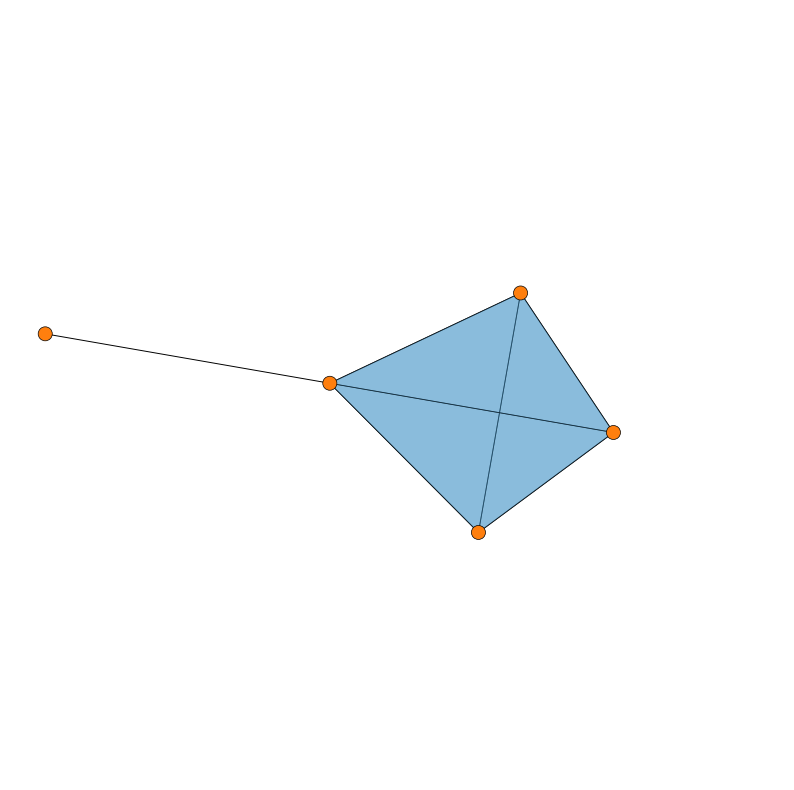

In [30]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
draw_2d_simplicial_complex(simplices, ax=ax)